## IMPORTER

In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.stats
import datetime
import pandas as pd
from my_site.image.Traitement_image.Preprocessing_for_cropped import preproc_and_crop
from my_site.image.utilities.Path_Join import p_join
from dateutil.relativedelta import relativedelta
from numpy.random import randint, random

## ALGORITHME EXPECTATION MAXIMAZATION

In [2]:
# input fllename >> output 3d array
def read_img(filename, center, shape):
    img_3d = mpimg.imread(filename)
    prepro = preproc_and_crop(img_3d, center, shape)
    return prepro


# input 3d array >> output 2d array
def flatten_img(img_3d):
    x, y = img_3d.shape
    img_2d = img_3d.reshape(x * y, 1)
    img_2d = np.array(img_2d, dtype=np.float64)
    return img_2d


# input 2d array >> output 3d array
def recover_img(img_2d, X, Y, vis=False):
    img_2d = cv2.resize(img_2d, (0, 0), fx=10, fy=10)
    recover_img = img_2d.reshape(X, Y)
    return recover_img


def random_init(img, k):
    # For gray-scale
    if len(img.shape) == 1:
        means = randint(low=0, high=255, size=(k, 1))
        cov = randint(low=0, high=500, size=k)
        pis = random(size=k)
    else:
        z = img.shape[1]
        means = randint(low=0, high=255, size=(k, z))
        cov = randint(low=0, high=500, size=(k, z, z))
        pis = random(size=k)
    return means, cov, pis


# E-Step: Update Parameters
# update the conditional pdf - prob that pixel i given class j
def update_responsibility(img, means, cov, pis, k):
    # responsibilities: i th pixels, j th class
    # pis * gaussian.pdf
    responsibilities = np.array(
        [pis[j] * scipy.stats.multivariate_normal.pdf(img, mean=means[j], cov=cov[j]) for j in range(k)]).T
    # normalize for each row
    norm = np.sum(responsibilities, axis=1)
    # convert to column vector
    norm = np.reshape(norm, (len(norm), 1))
    responsibilities = responsibilities / norm
    return responsibilities


# update pi for each class of Gaussian model
def update_pis(responsibilities):
    pis = np.sum(responsibilities, axis=0) / responsibilities.shape[0]
    return pis


# update means for each class of Gaussian model
def update_means(img, responsibilities):
    means = []
    class_n = responsibilities.shape[1]
    for j in range(class_n):
        weight = responsibilities[:, j] / np.sum(responsibilities[:, j])
        weight = np.reshape(weight, (1, len(weight)))
        means_j = weight.dot(img)
        means.append(means_j[0])
    means = np.array(means)
    return means


# update covariance matrix for each class of Gaussian model
def update_covariance(img, responsibilities, means):
    cov = []
    class_n = responsibilities.shape[1]
    for j in range(class_n):
        weight = responsibilities[:, j] / np.sum(responsibilities[:, j])
        weight = np.reshape(weight, (1, len(weight)))
        # Each pixels have a covariance matrice
        covs = [np.mat(i - means[j]).T * np.mat(i - means[j]) for i in img]
        # Weighted sum of covariance matrices
        cov_j = sum(weight[0][i] * covs[i] for i in range(len(weight[0])))
        cov.append(cov_j)
    cov = np.array(cov)
    return cov


# M-step: choose a label that maximise the likelihood
def update_labels(responsibilities):
    labels = np.argmax(responsibilities, axis=1)
    return labels


def update_loglikelihood(img, means, cov, pis, k):
    pdf = np.array([pis[j] * scipy.stats.multivariate_normal.pdf(img, mean=means[j], cov=cov[j]) for j in range(k)])
    log_ll = np.log(np.sum(pdf, axis=0))
    log_ll_sum = np.sum(log_ll)
    return log_ll_sum


def EM_cluster(img, k, error=10e-3, iter_n=1000):
    #  init setting
    start_dt1 = datetime.datetime.now()
    cnt = 0
    likelihood_arr = []
    means_arr = []
    means, cov, pis = random_init(img, k)
    likelihood = 0
    new_likelihood = 2
    means_arr.append(means)
    responsibilities = update_responsibility(img, means, cov, pis, k)
    while (abs(likelihood - new_likelihood) > error) and (cnt != iter_n):
        start_dt = datetime.datetime.now()
        cnt += 1
        likelihood = new_likelihood
        # E-Step
        labels = update_labels(responsibilities)
        # M-step
        responsibilities = update_responsibility(img, means, cov, pis, k)
        means = update_means(img, responsibilities)
        cov = update_covariance(img, responsibilities, means)
        pis = update_pis(responsibilities)
        new_likelihood = update_loglikelihood(img, means, cov, pis, k)
        likelihood_arr.append(new_likelihood)
        end_dt = datetime.datetime.now()
        diff = relativedelta(end_dt, start_dt)
        print("iter: %s, time interval: %s:%s:%s:%s" % (cnt, diff.hours, diff.minutes, diff.seconds, diff.microseconds))
        print("log-likelihood = {}".format(new_likelihood))
        # Store means stat
        means_arr.append(means)
    likelihood_arr = np.array(likelihood_arr)
    print('Converge at iteration {}'.format(cnt + 1))
    end_dt1 = datetime.datetime.now()
    diff = relativedelta(end_dt1, start_dt1)
    print("duration time: %s:%s:%s:%s" % (diff.hours, diff.minutes, diff.seconds, diff.microseconds))
    return labels, means, cov, pis, likelihood_arr, means_arr

## TEST SUR UNE IMAGE

In [3]:
image_path_prepro = r'C:\Users\Asus\PycharmProjects\pythonProject1\temp\crop.jpg'
df = pd.read_excel(r"C:\Users\Asus\Desktop\PCD\Organized dataset\metadata\metadata_good2.0.xlsx")
parent_dir = r'C:\Users\Asus\Desktop\PCD\Organized dataset\curated'
number = 10
center = eval(df['center of roi'][number])
shape = eval(df['Shape of cropped image'][number])
image_path_raw = p_join(parent_dir, df['image full mammo path'][number])

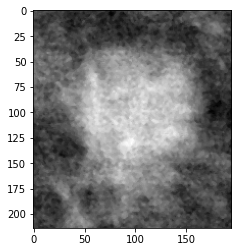

In [4]:
gray_img = read_img(filename=image_path_raw, center=center, shape=shape)
x, y = gray_img.shape
dim = (x, y)
plt.imshow(gray_img, cmap="gray")

## Cluster = 2

In [5]:
flat_im = flatten_img(gray_img)
labels, means, cov, pis, likelihood_arr, means_arr = EM_cluster(flat_im, 2, error=0.0001)
means = np.array([element[0] for element in means])
cov = [element[0][0] for element in cov]
em_img = means[labels]
recover_img = em_img.reshape(dim[0], dim[1])

iter: 1, time interval: 0:0:2:405887
log-likelihood = -222646.95328989753
iter: 2, time interval: 0:0:3:819248
log-likelihood = -221539.35495541885
iter: 3, time interval: 0:0:2:267883
log-likelihood = -221096.45674640543
iter: 4, time interval: 0:0:2:305741
log-likelihood = -220818.4125431192
iter: 5, time interval: 0:0:3:113219
log-likelihood = -220609.8791751988
iter: 6, time interval: 0:0:4:690667
log-likelihood = -220441.6047544703
iter: 7, time interval: 0:0:3:893898
log-likelihood = -220301.4531671375
iter: 8, time interval: 0:0:4:84090
log-likelihood = -220183.07452886374
iter: 9, time interval: 0:0:3:806212
log-likelihood = -220082.43720201834
iter: 10, time interval: 0:0:2:635508
log-likelihood = -219996.5716239505
iter: 11, time interval: 0:0:2:74007
log-likelihood = -219923.08515767104
iter: 12, time interval: 0:0:4:145038
log-likelihood = -219859.97260298367
iter: 13, time interval: 0:0:4:174127
log-likelihood = -219805.53707384475
iter: 14, time interval: 0:0:3:586063
log

In [10]:
import cv2
a = recover_img.min()
b = recover_img.max()
ret,th1 = cv2.threshold(recover_img,a+1,255,cv2.THRESH_BINARY)

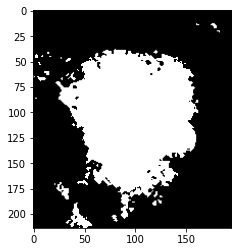

In [11]:
plt.imshow(recover_img,cmap="gray")

In [ ]:
plt.imshow(th1,cmap="gray")

In [18]:
from my_site.image.Traitement_image.Crop_From_Center import crop_image_from_center
import cv2

gt = mpimg.imread(p_join(parent_dir, df['ROI mask file path'][number]))
res = r"C:\Users\Asus\PycharmProjects\pythonProject1\image test algorithms\EM result\cluster__2.EM.jpg"
gt_crop = crop_image_from_center(gt, center, shape)
im = cv2.imread(res, cv2.IMREAD_GRAYSCALE)

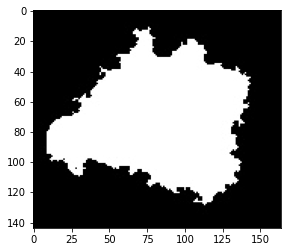

In [19]:
plt.imshow(gt_crop, cmap="gray")

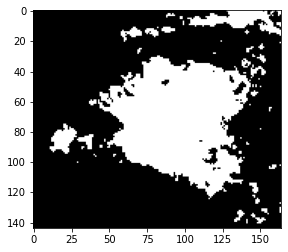

In [20]:
plt.imshow(recover_img, cmap="gray")
result = recover_img
#cv2.imwrite(r'C:\Users\Asus\PycharmProjects\pythonProject1\image test algorithms\EM result\cluster__2.EM.jpg',result)

In [21]:
print(result.shape)

(144, 164)


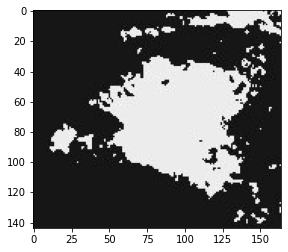

In [9]:
plt.imshow(im, cmap='gray')

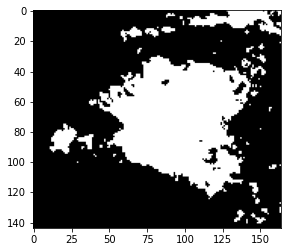

In [10]:
(thresh, blackAndWhiteImage) = cv2.threshold(im, 127, 255, cv2.THRESH_BINARY)
plt.imshow(blackAndWhiteImage, cmap='gray')

In [22]:
cv2.imwrite(r"C:\Users\Asus\PycharmProjects\pythonProject1\image test algorithms\EM result\cluster_2.EMblack&white.jpg",
            blackAndWhiteImage)

True

In [11]:
from my_site.image.utilities.IOU import iou
from my_site.image.utilities.Dice_coef import dice_coef

print(iou(blackAndWhiteImage, gt_crop))
print(dice_coef(blackAndWhiteImage, gt_crop))

IoU is 0.5445267341040463
0.5445267341040463
Dice coefficient is 0.7748983739837398
0.7748983739837398


## Cluster = 3

In [ ]:
labels2, means2, cov2, pis2, likelihood_arr2, means_arr2 = EM_cluster(flat_im, 3, error=0.001)
means2 = np.array([element[0] for element in means2])
cov2 = [element[0][0] for element in cov2]
em_img2 = means2[labels2]
recover_img2 = em_img2.reshape(dim[0], dim[1])

In [ ]:
plt.imshow(em_img2.reshape(dim[0], dim[1]), cmap="gray")
img = em_img2.reshape(dim[0], dim[1])
cv2.imwrite(r'C:\Users\Asus\PycharmProjects\pythonProject1\image test algorithms\EM result\cluster_3_2.0.jpg', img)

## TEST SUR 3 IMAGES

In [4]:
FILENAME_LIST = [r'C:\Users\Asus\Desktop\PCD\Organized dataset\images\P_00001\LEFT_CC_1\cropped.jpg',
                 r'C:\Users\Asus\Desktop\PCD\Organized dataset\images\P_00001\LEFT_MLO_1\cropped.jpg',
                 r'C:\Users\Asus\Desktop\PCD\Organized dataset\images\P_00004\LEFT_CC_1\cropped.jpg']

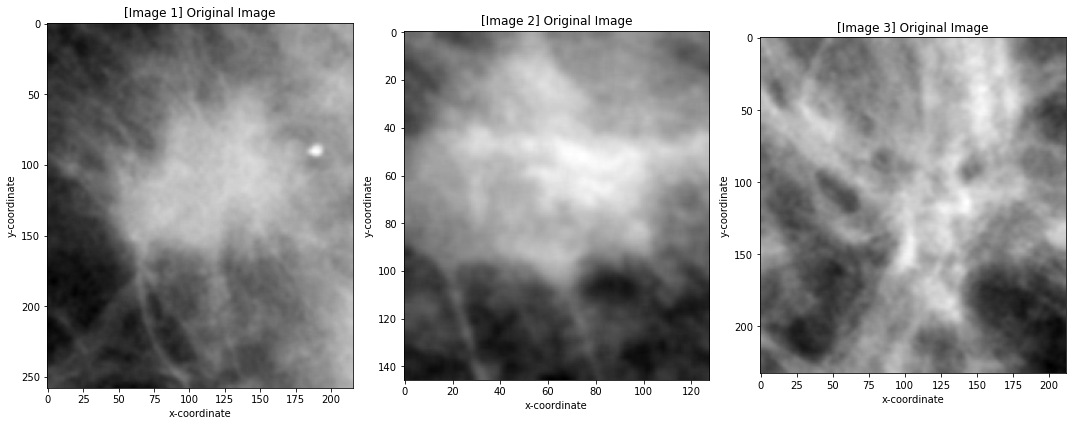

In [10]:
# Visualize demo images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
ax_list = [ax1, ax2, ax3]
gray_img_list = []
dim_img_list = []
i = 1
for filename, ax in zip(FILENAME_LIST, ax_list):
    gray_img = read_img(filename=filename, mode='L', size=(0.5, 0.5))
    x, y = gray_img.shape
    # Store dimension for each image
    dim_img_list.append((x, y))
    # Store img
    gray_img_list.append(gray_img)
    ax.imshow(gray_img, cmap='gray')
    ax.set_title('[Image {}] Original Image'.format(i))
    ax.axes.set_xlabel('x-coordinate')
    ax.axes.set_ylabel('y-coordinate')
    i += 1

plt.tight_layout()
fig.savefig('orig_images.pdf')

In [ ]:
img_list = [flatten_img(image) for image in gray_img_list]

In [11]:
# Init container
rand_likelihood_arr_list = []
rand_means_arr_list = []
rand_cov_arr_list = []
rand_pis_arr_list = []
rand_em_img_list = []
rand_means_list = []
for img, dim in zip(img_list, dim_img_list):
    labels, means, cov, pis, likelihood_arr, means_arr = EM_cluster(img, 3, error=0.01)
    means = np.array([element[0] for element in means])
    cov = [element[0][0] for element in cov]
    em_img = means[labels]
    recover_img = em_img.reshape(dim[0], dim[1])
    # store required stat
    rand_likelihood_arr_list.append(likelihood_arr)
    rand_means_arr_list.append(means_arr)
    rand_cov_arr_list.append(cov)
    rand_pis_arr_list.append(pis)
    rand_em_img_list.append(recover_img)
    rand_means_list.append(means)

iter: 1, time interval: 0:0:4:411629
log-likelihood = -285640.09608076414
iter: 2, time interval: 0:0:3:794811
log-likelihood = -285393.2184032325
iter: 3, time interval: 0:0:3:771914
log-likelihood = -285228.57094500645
iter: 4, time interval: 0:0:3:794256
log-likelihood = -285081.79339480307
iter: 5, time interval: 0:0:3:810173
log-likelihood = -284962.9078460022
iter: 6, time interval: 0:0:3:794402
log-likelihood = -284877.76958776923
iter: 7, time interval: 0:0:3:879353
log-likelihood = -284823.1784123454
iter: 8, time interval: 0:0:3:810106
log-likelihood = -284790.78648502304
iter: 9, time interval: 0:0:3:809709
log-likelihood = -284772.08403996885
iter: 10, time interval: 0:0:3:771854
log-likelihood = -284760.8927212247
iter: 11, time interval: 0:0:3:826201
log-likelihood = -284753.5304126751
iter: 12, time interval: 0:0:3:810276
log-likelihood = -284748.0632540149
iter: 13, time interval: 0:0:3:794042
log-likelihood = -284743.55404561
iter: 14, time interval: 0:0:3:809890
log-l

iter: 111, time interval: 0:0:13:875375
log-likelihood = -284643.23290529626
iter: 112, time interval: 0:0:14:636194
log-likelihood = -284643.00684435223
iter: 113, time interval: 0:0:16:995809
log-likelihood = -284642.78466771054
iter: 114, time interval: 0:0:18:451044
log-likelihood = -284642.56628137175
iter: 115, time interval: 0:0:13:330247
log-likelihood = -284642.3515943366
iter: 116, time interval: 0:0:12:776596
log-likelihood = -284642.1405184908
iter: 117, time interval: 0:0:13:126433
log-likelihood = -284641.9329684948
iter: 118, time interval: 0:0:14:638292
log-likelihood = -284641.7288616784
iter: 119, time interval: 0:0:16:227261
log-likelihood = -284641.52811794024
iter: 120, time interval: 0:0:12:238495
log-likelihood = -284641.3306596506
iter: 121, time interval: 0:0:9:386925
log-likelihood = -284641.13641156
iter: 122, time interval: 0:0:9:589671
log-likelihood = -284640.9453007098
iter: 123, time interval: 0:0:12:969698
log-likelihood = -284640.75725634844
iter: 124,

iter: 220, time interval: 0:0:8:36623
log-likelihood = -284630.8515509487
iter: 221, time interval: 0:0:8:912366
log-likelihood = -284630.79903261503
iter: 222, time interval: 0:0:11:601212
log-likelihood = -284630.7471043788
iter: 223, time interval: 0:0:8:70016
log-likelihood = -284630.69575883547
iter: 224, time interval: 0:0:7:869315
log-likelihood = -284630.6449887005
iter: 225, time interval: 0:0:11:906495
log-likelihood = -284630.5947868074
iter: 226, time interval: 0:0:14:601903
log-likelihood = -284630.54514610465
iter: 227, time interval: 0:0:10:602498
log-likelihood = -284630.49605965335
iter: 228, time interval: 0:0:8:227495
log-likelihood = -284630.44752062473
iter: 229, time interval: 0:0:6:391085
log-likelihood = -284630.3995222981
iter: 230, time interval: 0:0:5:829120
log-likelihood = -284630.3520580582
iter: 231, time interval: 0:0:6:221316
log-likelihood = -284630.3051213933
iter: 232, time interval: 0:0:6:965925
log-likelihood = -284630.2587058926
iter: 233, time in

iter: 329, time interval: 0:0:6:343990
log-likelihood = -284627.50631302304
iter: 330, time interval: 0:0:5:18584
log-likelihood = -284627.49051011243
iter: 331, time interval: 0:0:5:888872
log-likelihood = -284627.4748817831
iter: 332, time interval: 0:0:6:593565
log-likelihood = -284627.459426201
iter: 333, time interval: 0:0:5:300136
log-likelihood = -284627.44414155104
iter: 334, time interval: 0:0:5:897942
log-likelihood = -284627.42902603716
iter: 335, time interval: 0:0:5:970618
log-likelihood = -284627.414077882
iter: 336, time interval: 0:0:4:799924
log-likelihood = -284627.3992953267
iter: 337, time interval: 0:0:5:842013
log-likelihood = -284627.3846766308
iter: 338, time interval: 0:0:8:727490
log-likelihood = -284627.37022007175
iter: 339, time interval: 0:0:8:138747
log-likelihood = -284627.3559239451
iter: 340, time interval: 0:0:9:884211
log-likelihood = -284627.34178656375
iter: 341, time interval: 0:0:7:175523
log-likelihood = -284627.32780625817
iter: 342, time inter

iter: 68, time interval: 0:0:4:15429
log-likelihood = -98136.25829012999
iter: 69, time interval: 0:0:4:50780
log-likelihood = -98135.64580894471
iter: 70, time interval: 0:0:3:652837
log-likelihood = -98135.09762600469
iter: 71, time interval: 0:0:4:617548
log-likelihood = -98134.60666481637
iter: 72, time interval: 0:0:4:784673
log-likelihood = -98134.1666454272
iter: 73, time interval: 0:0:4:650168
log-likelihood = -98133.77199735324
iter: 74, time interval: 0:0:5:535544
log-likelihood = -98133.41778058515
iter: 75, time interval: 0:0:5:118284
log-likelihood = -98133.09961440817
iter: 76, time interval: 0:0:3:486788
log-likelihood = -98132.81361360553
iter: 77, time interval: 0:0:5:430370
log-likelihood = -98132.5563315213
iter: 78, time interval: 0:0:4:351792
log-likelihood = -98132.32470941526
iter: 79, time interval: 0:0:4:307700
log-likelihood = -98132.11603153253
iter: 80, time interval: 0:0:4:885049
log-likelihood = -98131.92788532427
iter: 81, time interval: 0:0:3:63989
log-l

iter: 67, time interval: 0:0:6:873963
log-likelihood = -256075.03096324517
iter: 68, time interval: 0:0:6:350076
log-likelihood = -256074.11560405412
iter: 69, time interval: 0:0:5:914037
log-likelihood = -256073.24304297878
iter: 70, time interval: 0:0:6:98778
log-likelihood = -256072.41075274616
iter: 71, time interval: 0:0:5:760839
log-likelihood = -256071.61637786904
iter: 72, time interval: 0:0:5:659383
log-likelihood = -256070.85772184524
iter: 73, time interval: 0:0:5:849306
log-likelihood = -256070.13273535887
iter: 74, time interval: 0:0:7:396268
log-likelihood = -256069.43950540386
iter: 75, time interval: 0:0:5:522273
log-likelihood = -256068.77624526105
iter: 76, time interval: 0:0:6:411372
log-likelihood = -256068.1412852592
iter: 77, time interval: 0:0:6:153500
log-likelihood = -256067.53306425875
iter: 78, time interval: 0:0:6:364182
log-likelihood = -256066.95012180076
iter: 79, time interval: 0:0:6:455959
log-likelihood = -256066.39109086647
iter: 80, time interval: 0:

iter: 176, time interval: 0:0:3:440151
log-likelihood = -256049.72388603055
iter: 177, time interval: 0:0:3:377763
log-likelihood = -256049.6738864557
iter: 178, time interval: 0:0:3:587325
log-likelihood = -256049.6246436858
iter: 179, time interval: 0:0:3:477648
log-likelihood = -256049.57614195484
iter: 180, time interval: 0:0:3:524518
log-likelihood = -256049.52836594117
iter: 181, time interval: 0:0:3:509551
log-likelihood = -256049.4813007514
iter: 182, time interval: 0:0:3:424964
log-likelihood = -256049.43493190527
iter: 183, time interval: 0:0:3:430963
log-likelihood = -256049.38924532125
iter: 184, time interval: 0:0:3:424152
log-likelihood = -256049.34422730224
iter: 185, time interval: 0:0:3:439850
log-likelihood = -256049.29986452233
iter: 186, time interval: 0:0:3:408909
log-likelihood = -256049.25614401395
iter: 187, time interval: 0:0:3:393585
log-likelihood = -256049.2130531553
iter: 188, time interval: 0:0:3:424758
log-likelihood = -256049.17057965894
iter: 189, time 

iter: 285, time interval: 0:0:3:531085
log-likelihood = -256046.8264009791
iter: 286, time interval: 0:0:3:440053
log-likelihood = -256046.81328700422
iter: 287, time interval: 0:0:3:377980
log-likelihood = -256046.8003078693
iter: 288, time interval: 0:0:3:393457
log-likelihood = -256046.78746187923
iter: 289, time interval: 0:0:3:386720
log-likelihood = -256046.77474736492
iter: 290, time interval: 0:0:3:409201
log-likelihood = -256046.76216268275
iter: 291, time interval: 0:0:3:361734
log-likelihood = -256046.749706214
iter: 292, time interval: 0:0:3:424793
log-likelihood = -256046.73737636476
iter: 293, time interval: 0:0:3:408957
log-likelihood = -256046.72517156487
iter: 294, time interval: 0:0:3:425033
log-likelihood = -256046.7130902681
iter: 295, time interval: 0:0:3:361721
log-likelihood = -256046.7011309514
iter: 296, time interval: 0:0:3:339312
log-likelihood = -256046.68929211443
iter: 297, time interval: 0:0:3:361886
log-likelihood = -256046.6775722793
iter: 298, time int

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
ax_list = [ax1, ax2, ax3]
i = 1
# FIRST ROW: display image segment
for rand_em_img, ax in zip(rand_em_img_list, ax_list):
    ax.imshow(rand_em_img, cmap='gray')
    ax.set_title('[Image {}] Segmentation by EM'.format(i))
    # Set x-axis, y-axis
    ax.axes.set_xlabel('x-coordinate')
    ax.axes.set_ylabel('y-coordinate')
    i += 1;

# Make a nice layout
plt.tight_layout();
fig.savefig('em_rand_init.pdf')